In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import dotenv
from pathlib import Path

env_file = "../.env"

if os.path.exists(env_file):
    dotenv.load_dotenv(env_file, verbose=True)
    print("Loaded environment variables from .env file.")

cwd = os.getcwd()
# for some reason appending to PATH you need it to be string
sys.path.append(str(Path(cwd).parent / "src"))
hf_access_token = os.getenv("HUGGINGFACE_API_KEY")

# from research_tools.gpu import get_gpus_available
# os.environ["CUDA_VISIBLE_DEVICES"] = ",".join([str(i) for i in get_gpus_available()])

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

Loaded environment variables from .env file.


In [52]:
from run_evals import get_model, get_split_time_schedule, generate_batch
import torch
from tqdm import tqdm
from torch import nn
import random
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
assert device == torch.device("cuda")

In [48]:
@torch.no_grad()
def v_edm_sampler(
    v_edm,
    latents,
    class_labels=None,
    num_steps=18,
    guide_w=0.0,
    use_ema=True,
    cfg=True,
    drop_prob=0.0,
    suppress_print=False,
    n_steps_1=None,
    n_steps_2=None,
):
    time_schedule = [(i / num_steps) for i in reversed(range(1, num_steps + 1))] + [0]
    time_schedule[0] = 1 - 1e-5
    if n_steps_1 is not None and n_steps_2 is not None:
        time_schedule = get_split_time_schedule(n_steps_1, n_steps_2, split=0.5)
    cnt = 0
    if not suppress_print:
        print(f"Time schedule: {time_schedule}")

    if class_labels is not None:
        class_labels = (
            nn.functional.one_hot(class_labels, num_classes=10)
            .type(torch.float32)
            .to(latents.device)
        )
        mask = torch.bernoulli(torch.ones_like(class_labels) * (1 - drop_prob))
        class_labels = class_labels * mask
        if cfg:
            class_labels = torch.cat([class_labels, torch.zeros_like(class_labels)])
    # Main sampling loop.
    x_next = latents.to(torch.float64).to(device) * time_schedule[0]

    rand_x = random.choice([10 + i for i in range(8)])
    rand_y = random.choice([10 + i for i in range(8)])

    random_trajs = [
        [x_next[i, 0, rand_x, rand_y].detach().cpu().item()]
        for i in range(latents.shape[0])
    ]
    middle = None
    for i in tqdm(range(len(time_schedule[:-1]))):
        t = (
            torch.ones((latents.shape[0] * (2 if cfg else 1),), device=device)
            * time_schedule[i]
        )
        t_next = (
            torch.ones((latents.shape[0] * (2 if cfg else 1),), device=x_next.device)
            * time_schedule[i + 1]
        )
        dt = t_next[0] - t[0]
        if cfg:
            x_hat = x_next.repeat(2, 1, 1, 1)
        else:
            x_hat = x_next

        vt = v_edm(x_hat, t, class_labels, use_ema=use_ema).to(torch.float64)
        x_next = x_hat + vt * dt

        # cfg guide
        if cfg:
            x_next_cond, x_next_uncond = x_next.chunk(2)
            x_next = (1 + guide_w) * x_next_cond - guide_w * x_next_uncond
        if i == (num_steps // 2):
            middle = x_next.clone().detach()
        random_trajs += [
            [x_next[i, 0, rand_x, rand_y].detach().cpu().item()]
            for i in range(latents.shape[0])
        ]

    return random_trajs

In [49]:
import os

# make dir called figs
os.makedirs("figs", exist_ok=True)

In [ ]:
model_dir = Path("./models")
model_paths = list(model_dir.glob("*.pth"))

for model_path in model_paths:
    model_path = model_path
    model = get_model(model_path)
    model = model.to(device)
    batch_size = 12
    n_steps_1 = 9
    n_steps_2 = 9
    x_T = torch.randn([batch_size, 1, 28, 28], device=device)
    # random from 0 to 9 inclusive
    c = torch.randint(0, 10, (batch_size,), device=device)
    trajs = v_edm_sampler(
        model,
        x_T,
        class_labels=c,
        guide_w=4.5,
        suppress_print=True,
        num_steps=18,
        n_steps_1=n_steps_1,
        n_steps_2=n_steps_2,
    )

    time_schedule = get_split_time_schedule(n_steps_1, n_steps_2, split=0.5)
    trajs = np.array(trajs).reshape(-1, batch_size)

    # there a e batch
    # plot x = time, y = value
    # plot new figure for each batch
    plt.figure()
    plt.title(f"Model {model_path.stem}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    for i in range(batch_size):
        plt.plot(time_schedule, trajs[:, i], label=f"Class {c[i].item()}")
    plt.savefig(f"figs/{model_path.stem}.png")

/mnt/align1_drive/tcqian/unlearning_order/diff_test/run_evals.py:295: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  v_edm = EDMVel(model=unet)
100%|██████████| 2/2 [00:00<00

torch.Size([16, 1, 28, 28])


100%|██████████| 10/10 [00:00<00:00, 89.17it/s]


torch.Size([16, 1, 28, 28])


100%|██████████| 2/2 [00:00<00:00, 85.52it/s]


torch.Size([16, 1, 28, 28])


100%|██████████| 10/10 [00:00<00:00, 100.20it/s]


torch.Size([16, 1, 28, 28])


100%|██████████| 2/2 [00:00<00:00, 89.70it/s]


torch.Size([16, 1, 28, 28])


100%|██████████| 10/10 [00:00<00:00, 92.12it/s]


torch.Size([16, 1, 28, 28])


100%|██████████| 2/2 [00:00<00:00, 97.69it/s]


torch.Size([16, 1, 28, 28])


100%|██████████| 10/10 [00:00<00:00, 97.92it/s]


torch.Size([16, 1, 28, 28])


100%|██████████| 2/2 [00:00<00:00, 93.83it/s]


torch.Size([16, 1, 28, 28])


100%|██████████| 10/10 [00:00<00:00, 98.40it/s]


torch.Size([16, 1, 28, 28])


100%|██████████| 2/2 [00:00<00:00, 90.33it/s]


torch.Size([16, 1, 28, 28])


100%|██████████| 10/10 [00:00<00:00, 96.48it/s]


torch.Size([16, 1, 28, 28])


100%|██████████| 2/2 [00:00<00:00, 89.13it/s]


torch.Size([16, 1, 28, 28])


100%|██████████| 10/10 [00:00<00:00, 93.71it/s]


torch.Size([16, 1, 28, 28])


100%|██████████| 2/2 [00:00<00:00, 89.90it/s]


torch.Size([16, 1, 28, 28])


100%|██████████| 10/10 [00:00<00:00, 97.48it/s]


torch.Size([16, 1, 28, 28])


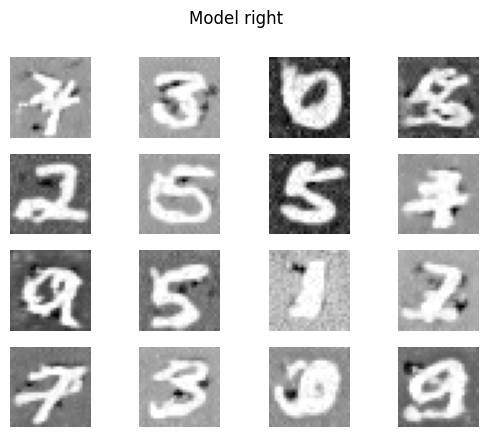

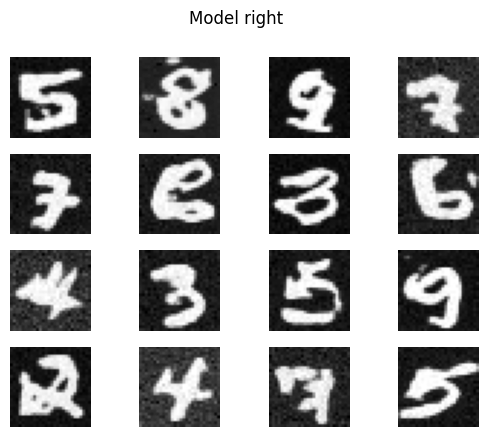

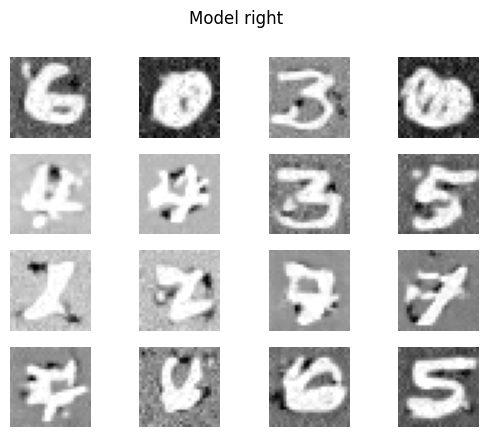

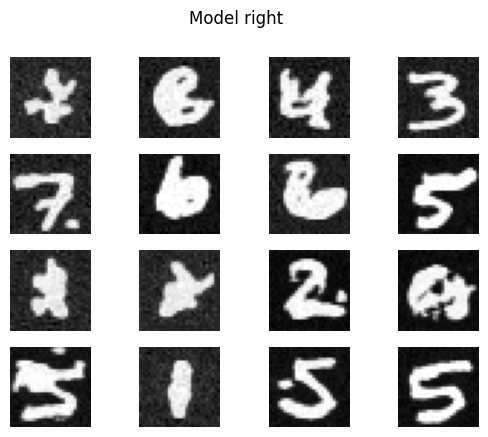

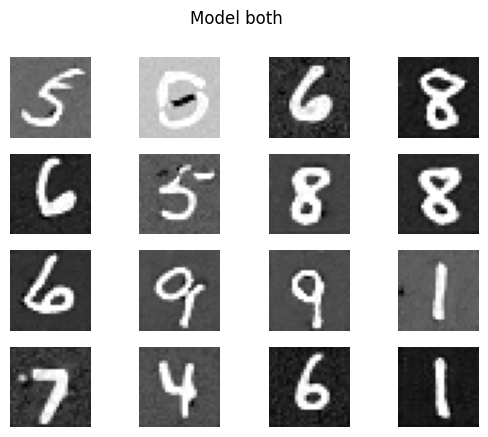

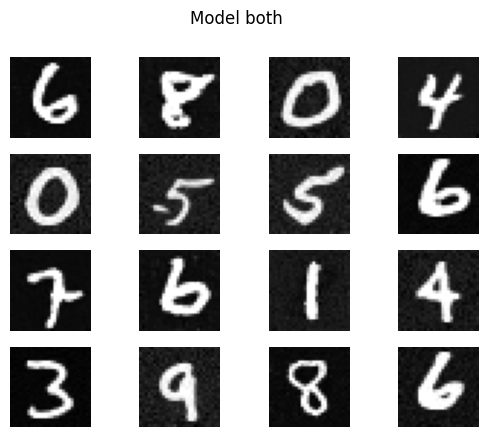

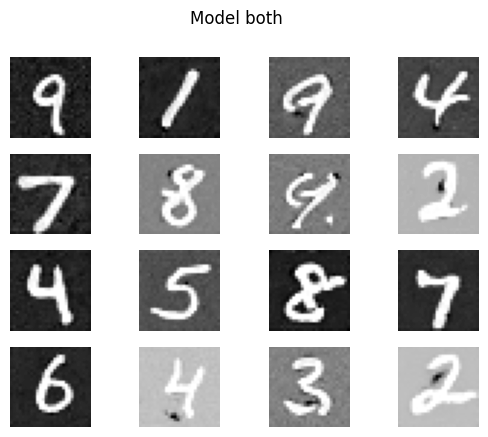

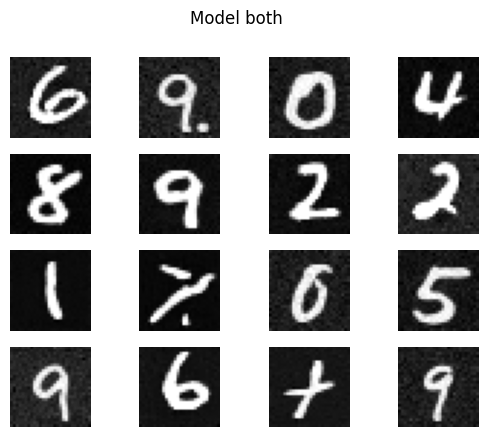

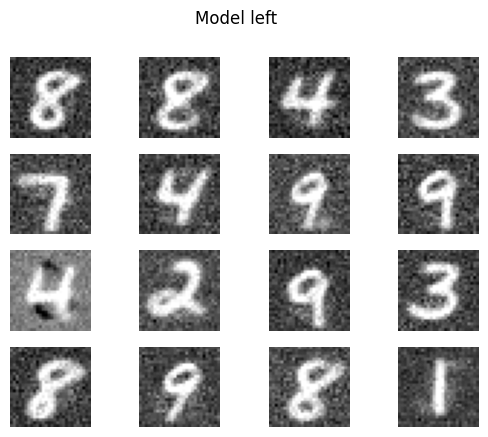

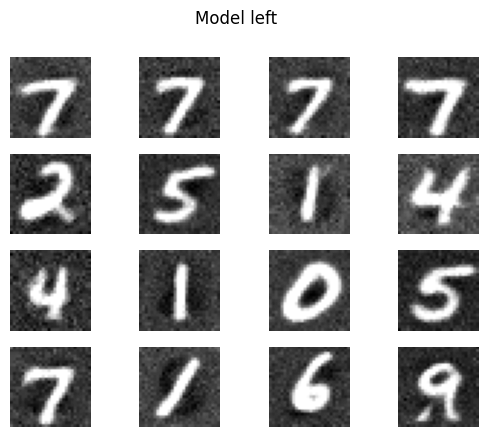

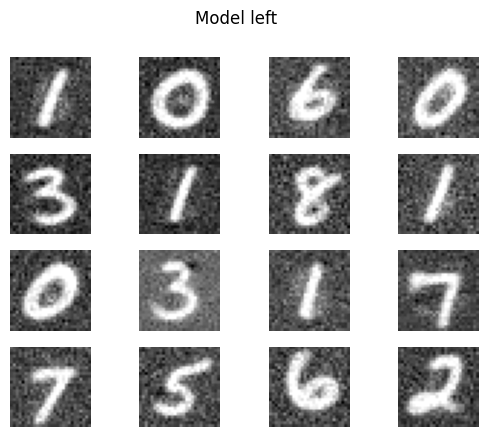

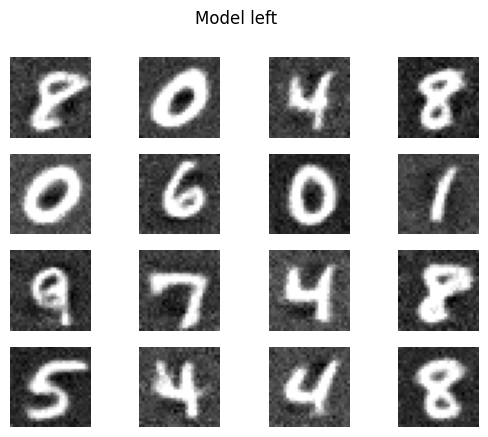

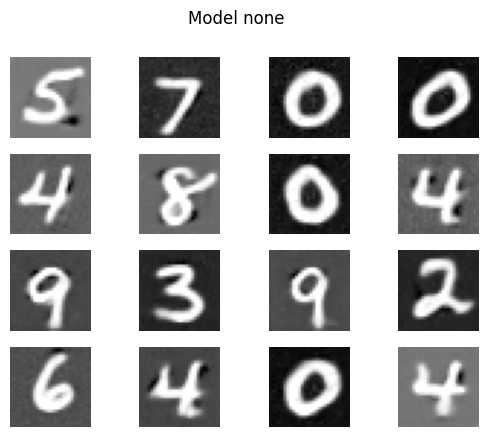

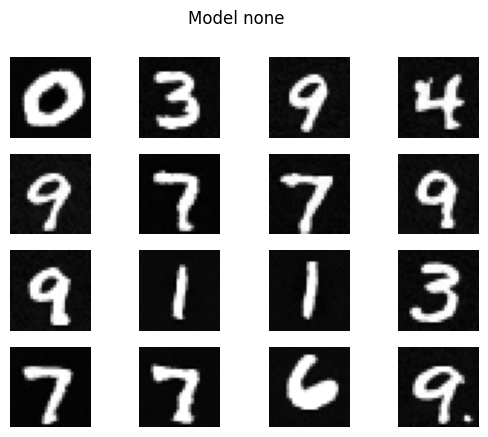

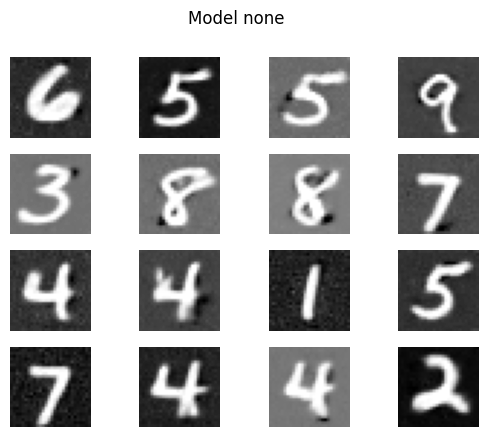

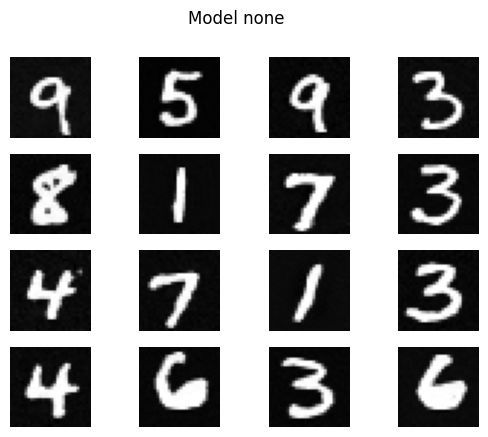

In [58]:
os.makedirs("samples", exist_ok=True)

for model_path in model_paths:
    model = get_model(model_path)
    model = model.to(device)
    batch_size = 16
    for n_step_1 in [1, 9]:
        for n_steps_2 in [1, 9]:
            results = generate_batch(model, batch_size, 18, n_steps_1, n_steps_2)
            results = (results / 2 + 0.5).clamp(0, 1)

            print(results.shape)
            # these are 16x1x28x28 black and white
            # plot these in 4x4 grid and svae to generations/model_name.png
            # from 0 to 1 values
            fig, axs = plt.subplots(4, 4)
            fig.suptitle(f"Model {model_path.stem}")
            for i in range(4):
                for j in range(4):
                    axs[i, j].imshow(results[i * 4 + j, 0].cpu().numpy(), cmap="gray")
                    axs[i, j].axis("off")
            save_path = Path(f"samples/{model_path.stem}")
            os.makedirs(save_path, exist_ok=True)
            plt.savefig(f"samples/{model_path.stem}/l_{n_step_1}_r_{n_steps_2}.png")